# Boilerplate

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [5]:
from skopt import (
    dummy_minimize, 
    gp_minimize, 
    forest_minimize, 
    gbrt_minimize
)

In [6]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [7]:
from hyperopt import hp, fmin, Trials
from hyperopt import anneal, tpe

# Dataset

In [8]:
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

In [9]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
# check balance of data
y.value_counts()/len(y)

0    0.627417
1    0.372583
dtype: float64

In [11]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

# Define the hyperparameter space

In [12]:
skopt_param_grid = [
    Integer(10, 120, name="n_estimators"),
    Integer(1, 5, name="max_depth"),
    Real(0.0001, 0.1, prior='log-uniform', name='learning_rate'),
    Real(0.001, 0.999, prior='log-uniform', name="min_samples_split"),
    Categorical(['deviance', 'exponential'], name="loss"),
]

In [13]:
hyperopt_param_grid = {
    'n_estimators': hp.quniform('n_estimators', 10, 120, 10),
    'max_depth': hp.quniform('max_depth', 1, 5, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'min_samples_split': hp.loguniform('min_samples_split', np.log(0.001), np.log(0.999)),
    'loss': hp.choice('loss', ['deviance', 'exponential'])
}

# Define the model

In [14]:
gbm = GradientBoostingClassifier(random_state=0)

# Define the objective function

In [15]:
@use_named_args(skopt_param_grid)
def skopt_objective(**params):
    gbm.set_params(**params)
    value = np.mean(
        cross_val_score(
            estimator=gbm,
            X=X_train,
            y=y_train,
            cv=3,
            n_jobs=-4,
            scoring='accuracy')
    )
    return -value

In [16]:
def hyperopt_objective(params):
    
    params_dict = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'min_samples_split': params['min_samples_split'],
        'loss': params['loss'],
        'random_state': 1000
    }

    gbm.set_params(**params_dict)
    value = np.mean(
        cross_val_score(
            estimator=gbm,
            X=X_train,
            y=y_train,
            cv=3,
            n_jobs=-4,
            scoring='accuracy')
    )
    return -value

# 1. Randomized Search

In [17]:
random_start = time.time()
random_search = dummy_minimize(
    skopt_objective,  
    skopt_param_grid,  
    n_calls=50,  
    random_state=0
)
random_time = time.time() - random_start

# 2. Bayesian Optimization with Gaussian Process

In [19]:
gp_start = time.time()
gp_search = gp_minimize(
    skopt_objective, 
    skopt_param_grid, 
    n_initial_points=10, 
    acq_func='EI', 
    n_calls=50, 
    random_state=0
)
gp_time = time.time() - gp_start

# 3. Bayesian Optimization with Random Forests

In [21]:
fm_start = time.time()
fm_search = forest_minimize(
    skopt_objective, 
    skopt_param_grid, 
    base_estimator = 'RF', 
    n_initial_points=10, 
    acq_func='EI', 
    n_calls=50, 
    random_state=0, 
    n_jobs=5,
)
fm_time = time.time() - fm_start

# 4. Bayesian Optimization with GBM

In [23]:
gbm_start = time.time()
gbm_search = gbrt_minimize(
    skopt_objective,
    skopt_param_grid, 
    n_initial_points=10, 
    acq_func='EI', 
    n_calls=50, 
    random_state=0, 
    n_jobs=5,
)
gbm_time = time.time() - gbm_start

# 5. Annealing Search

In [25]:
anneal_start = time.time()
trials_anneal = Trials()
anneal_search = fmin(
    fn=hyperopt_objective,
    space=hyperopt_param_grid,
    max_evals=50,
    algo=anneal.suggest,
    trials = trials_anneal
)
anneal_time = time.time() - anneal_start

100%|██████████| 50/50 [00:23<00:00,  2.09trial/s, best loss: -0.9497797524113313]


In [31]:
anneal_results = [trials_anneal.results[i]['loss'] for i in range(len(trials_anneal))]
mins_anneal = [np.min(anneal_results[:i]) for i in range(1, len(anneal_results)+1)]

# 6. Tree-structured Parzen Estimators Search

In [27]:
tpe_start = time.time()
trials_tpe = Trials()
tpe_search = fmin(
    fn=hyperopt_objective,
    space=hyperopt_param_grid,
    max_evals=50,
    algo=tpe.suggest,
    trials = trials_tpe
)
tpe_time = time.time() - tpe_start

100%|██████████| 50/50 [00:18<00:00,  2.75trial/s, best loss: -0.9522860180754918]


In [32]:
tpe_results = [trials_tpe.results[i]['loss'] for i in range(len(trials_tpe))]
mins_tpe = [np.min(tpe_results[:i]) for i in range(1, len(tpe_results)+1)]

# Plot Charts

In [40]:
names = ['random_search', 'gp_search', 'fm_search', 
        'gbm_search', 'anneal_search', 'tpe_search']
convergence_results = [random_search, gp_search, fm_search, gbm_search]
time_results = [random_time, gp_time, fm_time, gbm_time, anneal_time, tpe_time]

In [33]:
n_calls = len(convergence_results[0].x_iters)
iterations = range(1, n_calls+1)
mins = [[np.min(r.func_vals[:i]) for i in iterations]
                for r in convergence_results]
mins.append(mins_anneal)
mins.append(mins_tpe)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


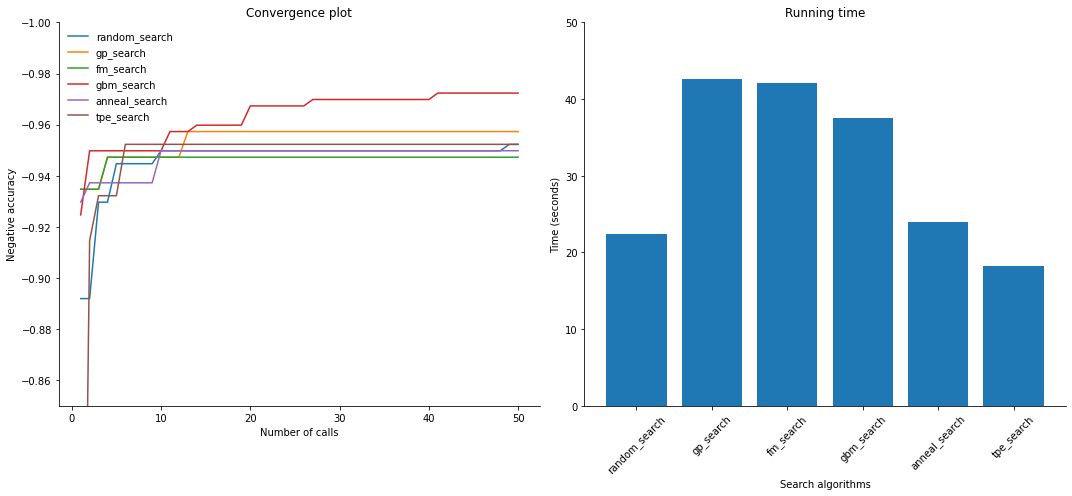

In [52]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
for min, name in zip(mins,names):
    axes[0].plot(iterations, min, label=name)
axes[0].set_ylim(-0.85, -1)
axes[0].set_title('Convergence plot')
axes[0].set_ylabel('Negative accuracy')
axes[0].set_xlabel('Number of calls')
axes[0].legend(frameon=False)

axes[1].bar(names, time_results)
axes[1].set_xticklabels(names, rotation=45)
axes[1].set_ylim(0,50)
axes[1].set_title('Running time')
axes[1].set_xlabel('Search algorithms')
axes[1].set_ylabel('Time (seconds)')

plt.tight_layout()
plt.show()
plt.savefig('convergence_plot.jpg')